## Feature Map Extraction

Load dependencies and specify working directory

In [12]:
%cd /home/jgjang/Maritime-MMDetection-HSI/

/home/jgjang/Maritime-MMDetection-HSI


In [14]:
from mmdet.apis import init_detector, inference_detector_final, show_result_pyplot

In [91]:
config_file = 'work_dirs/faster_rcnn_r50_fpn_1x_coco_final_v2/faster_rcnn_r50_fpn_1x_coco_final_v2.py'
checkpoint_file = 'work_dirs/faster_rcnn_r50_fpn_1x_coco_final_v2/epoch_3.pth'

In [92]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: work_dirs/faster_rcnn_r50_fpn_1x_coco_final_v2/epoch_3.pth


In [93]:
img = 'data/test/344.jpg'
hsi = 'data/test/344.mat'

In [94]:
result = inference_detector_final(model, img, hsi)

/home/jgjang/Maritime-MMDetection-HSI/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


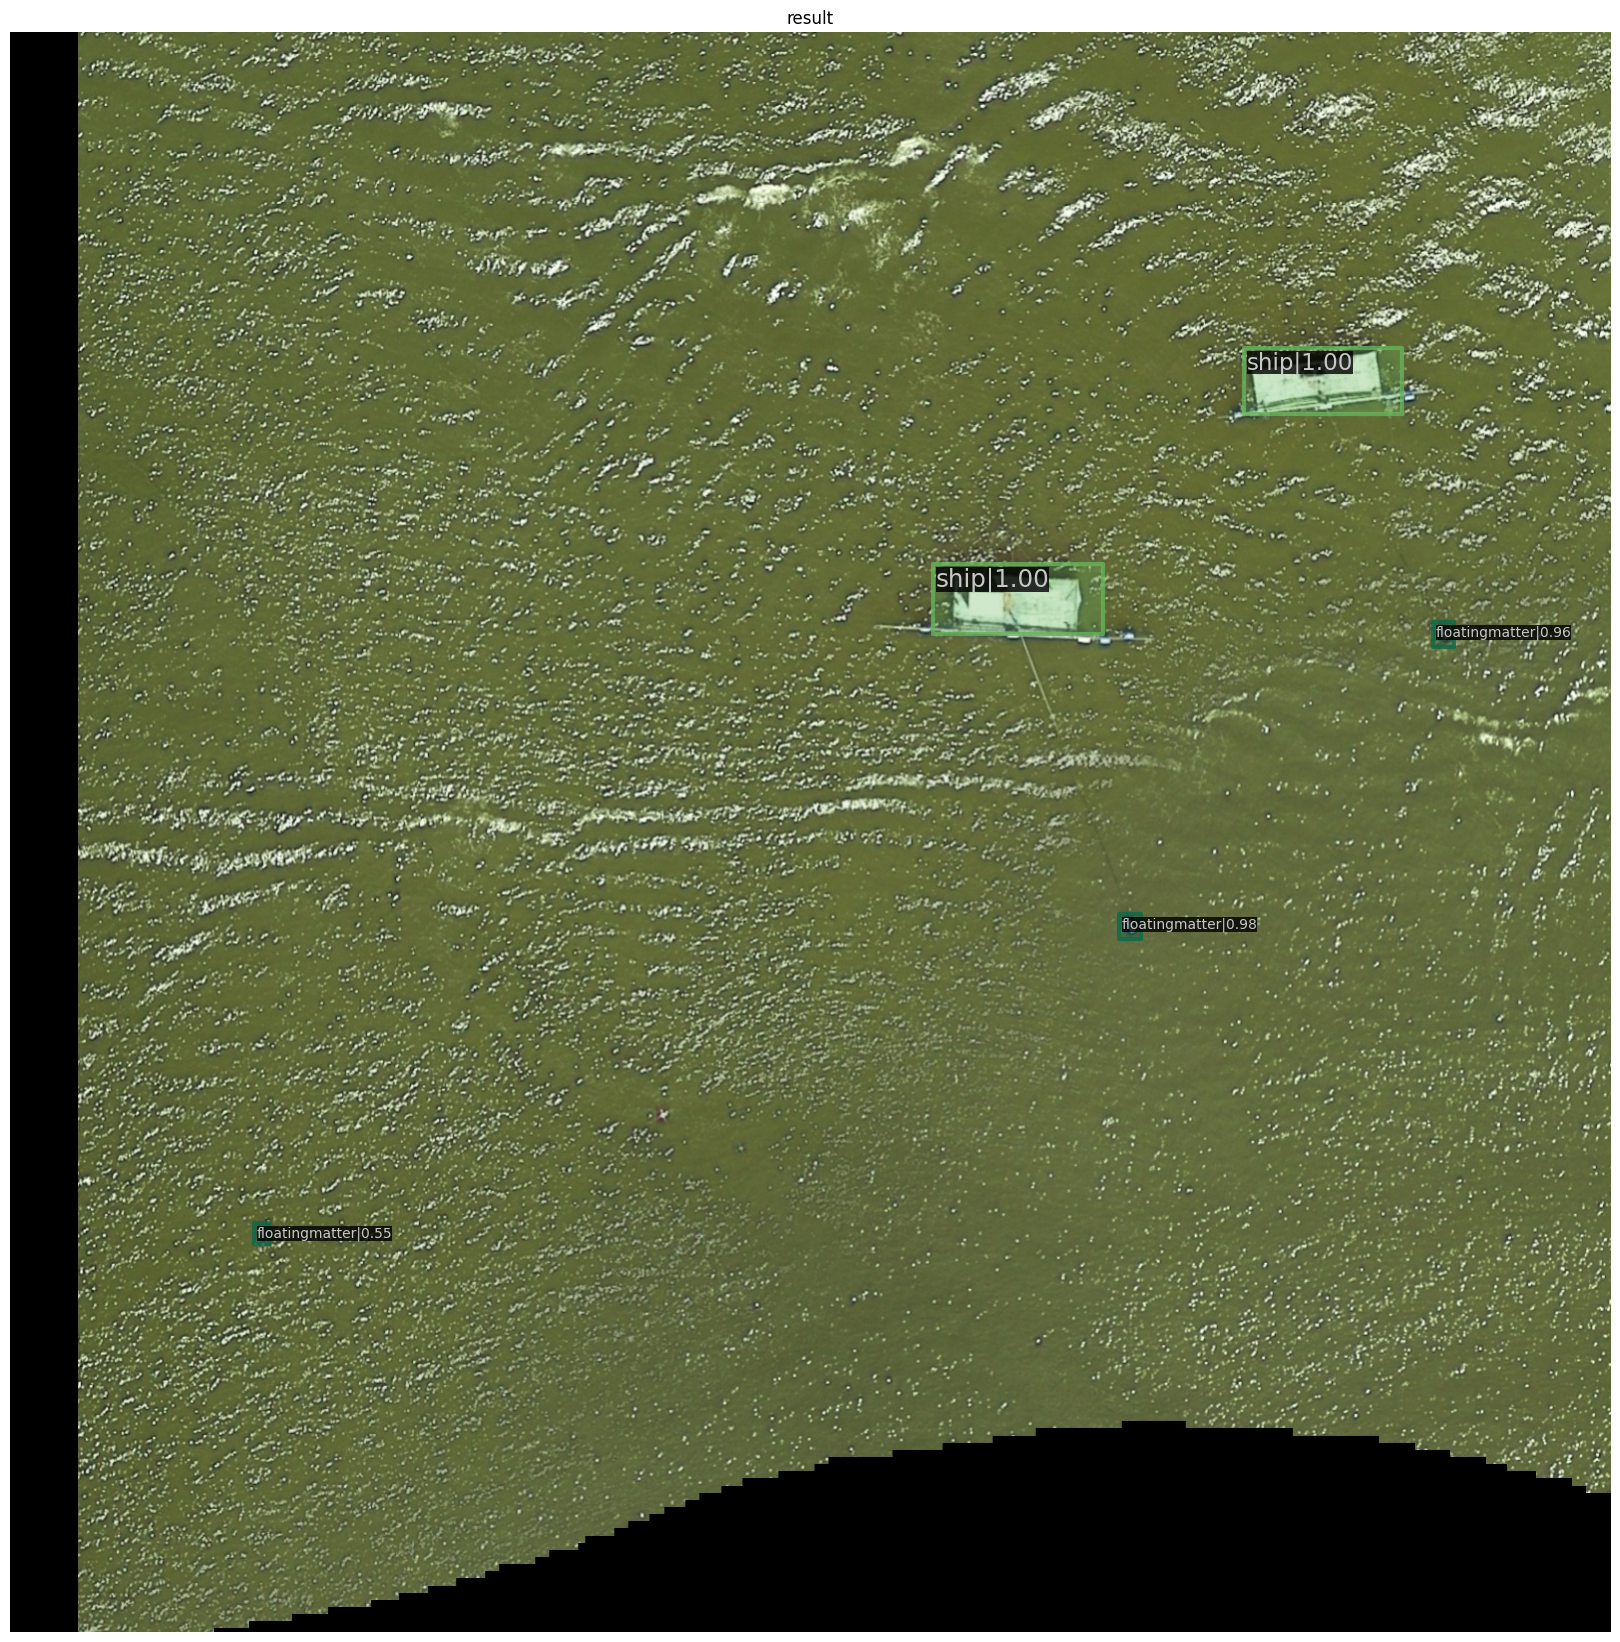

In [95]:
show_result_pyplot(model,img,result, score_thr=0.5)

In [73]:
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter
from itertools import zip_longest

cfg = model.cfg
cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
test_pipeline = Compose(cfg.data.test.pipeline)

datas = []
data = dict(img_info=dict(filename=img), hsi_info = dict(filename=hsi), img_prefix=None)
data = test_pipeline(data)
datas.append(data)
data = collate(datas, samples_per_gpu=1)

data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
data['img'] = [img.data[0] for img in data['img']]
data['hsi'] = [hsi.data[0] for hsi in data['hsi']]

x = model.backbone(data['img'][0].cuda())
x_hsi = model.backbone_hsi(data['hsi'][0].cuda())
x = [i for j in zip_longest(x,x_hsi) for i in j if i is not None]
x = model.neck(x)
print(x[0].size())

torch.Size([1, 256, 400, 400])


In [74]:
import torch
processed = []
for feature_map in x:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(400, 400)
(200, 200)
(200, 200)
(100, 100)
(100, 100)
(50, 50)
(50, 50)
(25, 25)
(25, 25)


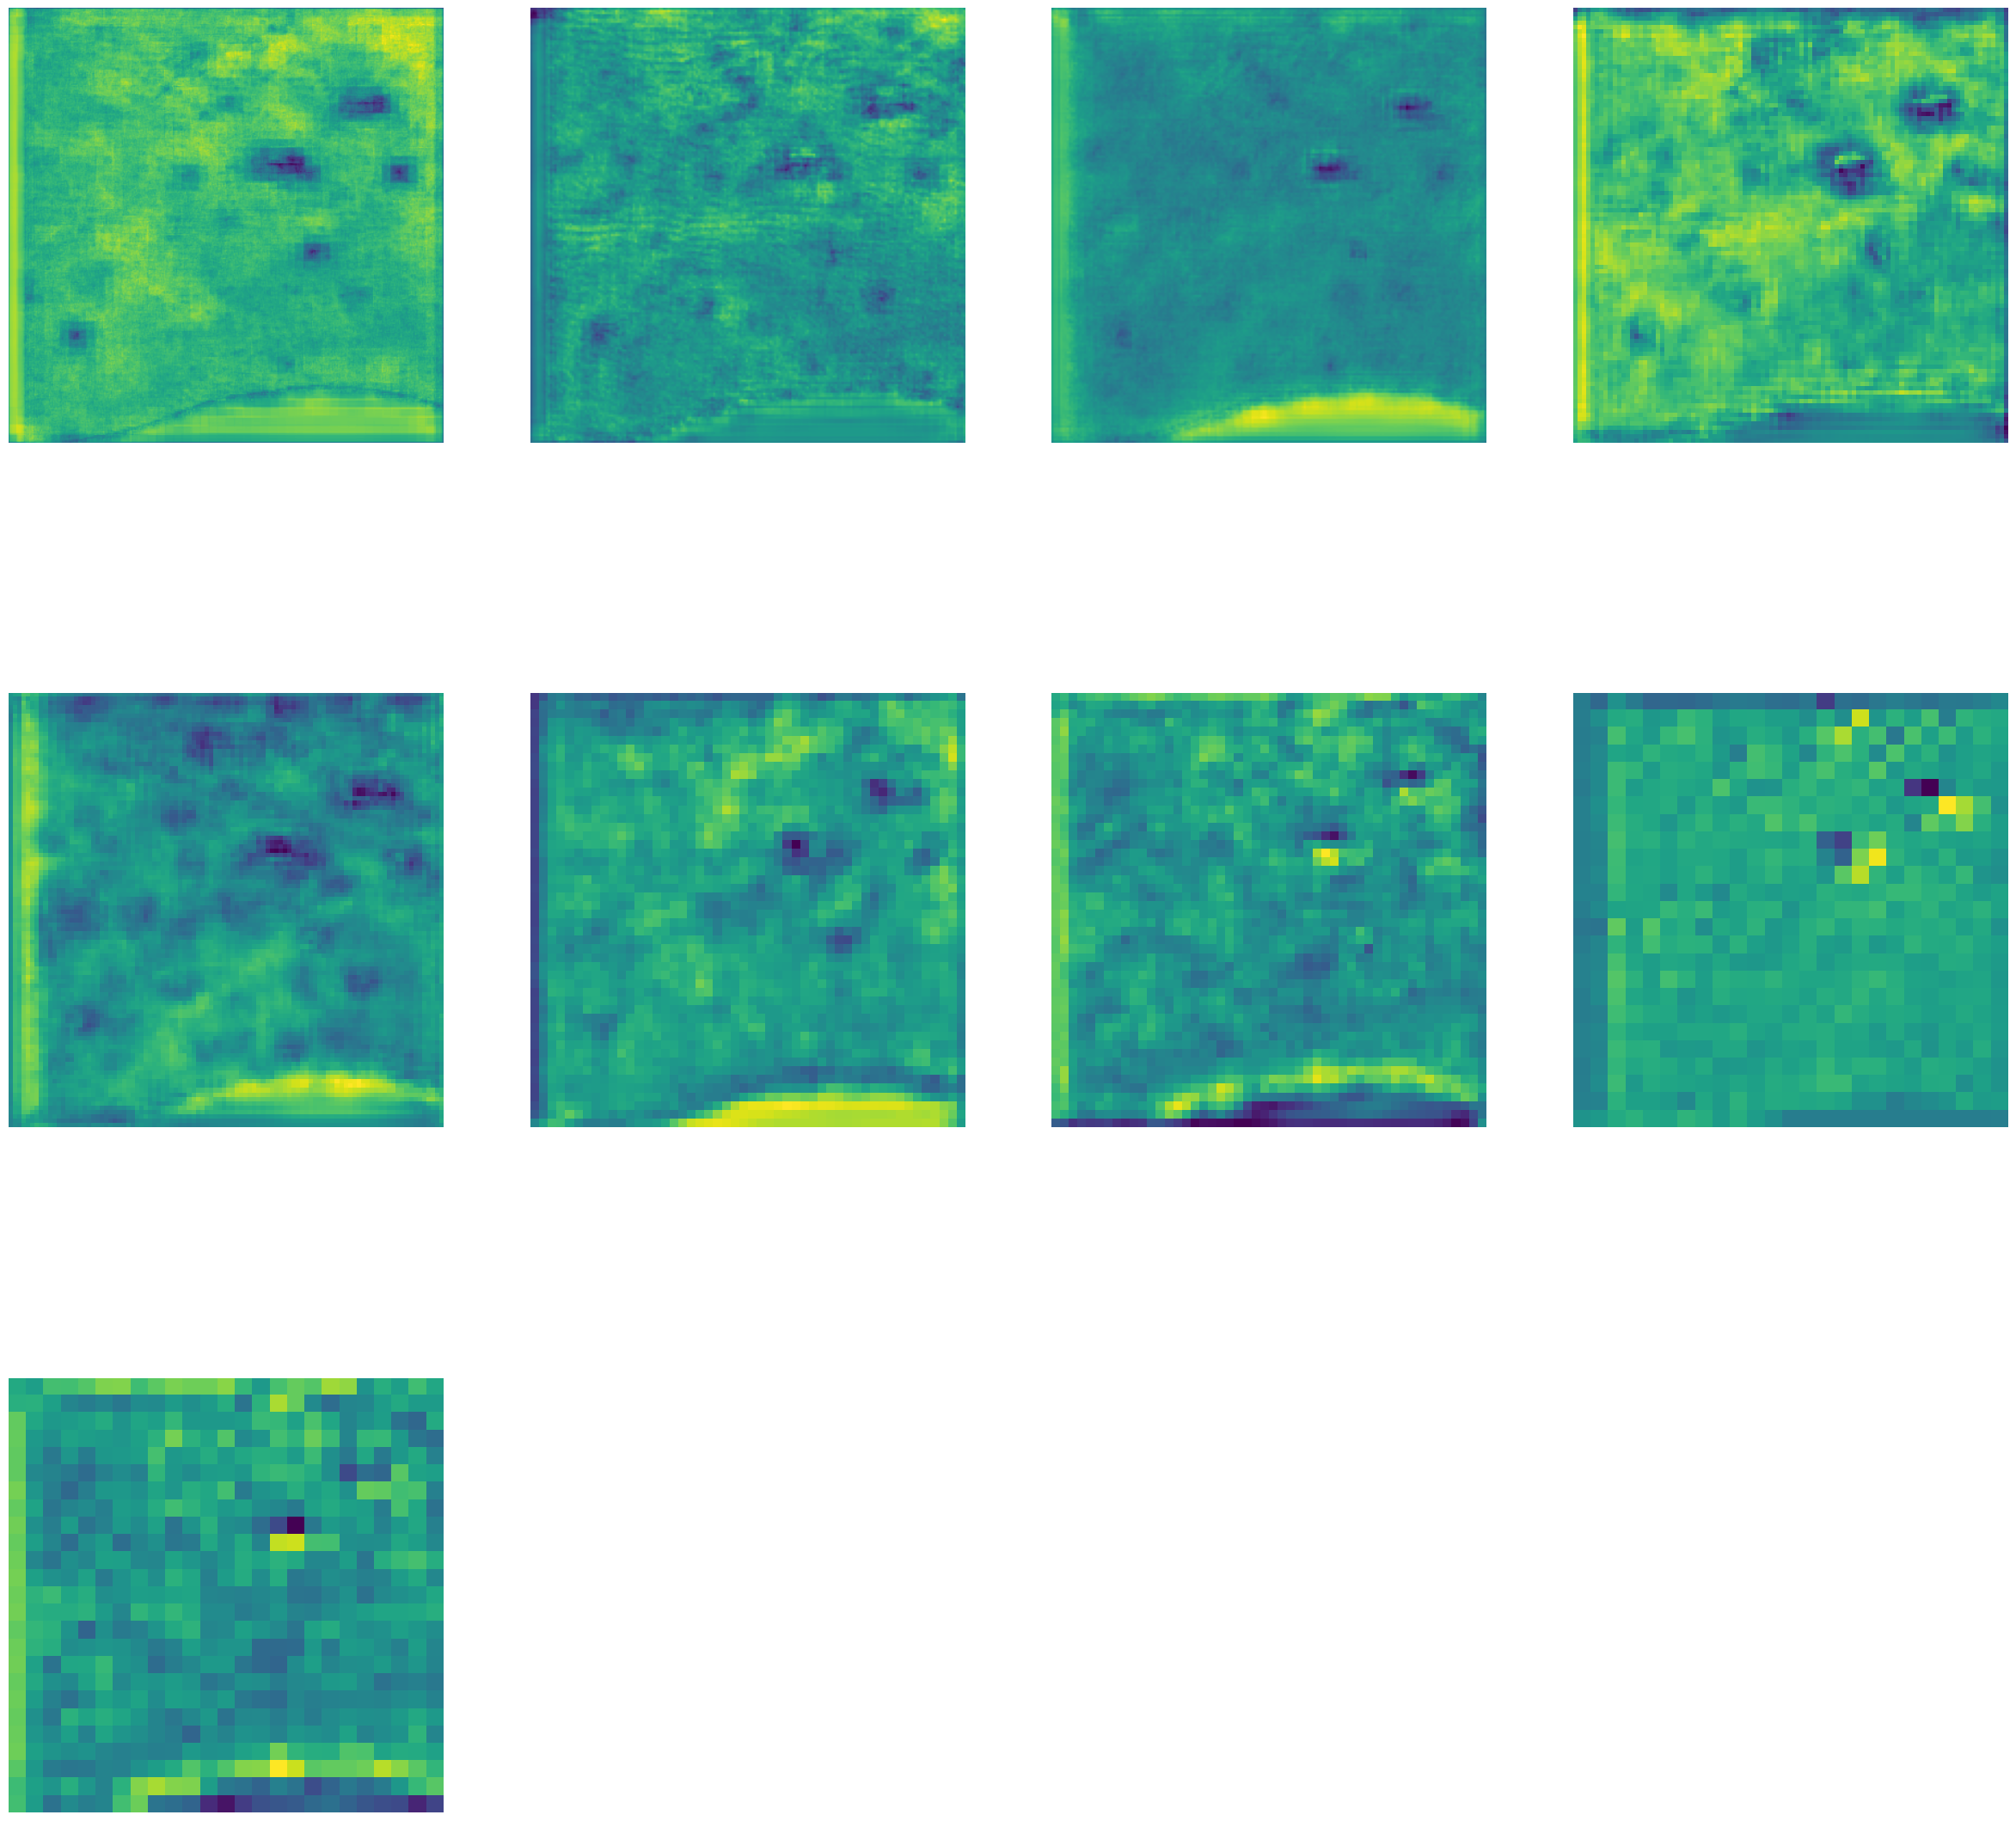

In [75]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    # a.set_title(names[i].split('(')[0], fontsize=30)